In [1]:
import numpy as np
import pickle
import os
import shutil
import pandas as pd
import sys
import matplotlib.pyplot as plt
import yaml
import astropy.io.fits as pf
# from astropy.table import Table
# import healpy as hp
import h5py as h5
import joblib
import treecorr
from scipy.stats import chi2




In [2]:
import h5py as h5
import healsparse
import joblib
import healpy as hp

def convert_to_pix_coord(ra, dec, nside=1024,nest=False):
    """
    Converts RA,DEC to hpix coordinates
    """

    theta = (90.0 - dec) * np.pi / 180.
    #print theta
    phi = ra * np.pi / 180.
    pix = hp.ang2pix(nside, theta, phi, nest=nest)

    return pix


In [3]:
# change with the path of this repo 
base_dir = '/global/cfs/cdirs/des/giannini/ggl/'

#### 1) Gamma x 

The cross component of the shear is expected to be zero

Requirement – measured signal has to be consistent with null signal (Δχ2 < 1)

#### 2) Random signal 

Random signal consistency with null signal - the tangential shear measured around a random catalog is expected to be zero

Requirement – measured signal has to be consistent with null signal (Δχ2 < 1)

#### 3) PSF Residuals 

We cross-correlate the lens sample with:
ellipticities estimated after subtracting the PSF model shape to the stars measured shape (e_star-e_psf)
ellipticities estimated after subtracting the PSF model size to the stars measured size (e_psf*(T_star-T_psf)/T_psf)
For each case (shape and size), we repeat the test for the following two scenarios
dividing the lens sample in tomo bins
using different PSF models estimated for each griz band

Requirement – measured signal has to be consistent with null signal (Δχ2 < 1)

#### 4) Scalar Response 

Test whether the approximation of the response matrix as scalar is valid:
We construct the response matrix for the full sample to maximize s/n (ie. using the full sample)

Requirement – 
- Check whether the off-diagonal terms are sufficiently small compared to the diagonal terms (<1%)
- Check whether the two diagonal terms are sufficiently similar (<1%)


#### 5) Scale-dependent Response 

Test whether the approximation of using a single value of R per tomographic bin is valid:
Perform NKCorrelations of the sheared ellipticities to obtain R(θ)

Requirement – The difference of the fiducial signal with respect to the signal measured without one of the above corrections should be below Δχ2 <1. 


#### 6) Other corrections 

We test the impact of three corrections to the tangential shear estimator:
- LSS weights
- Boost factors
- Response

Requirement – The difference of the fiducial signal with respect to the signal measured without one of the above corrections should be within uncertainties at all the scales considered for the analysis. Also, we expect the Δχ2 to be consistent with what was found in Y3. We qualitatively exam the chi2 numbers but do not put a specific threshold for passing. 

#### Other tests that we may do but do not place quantitative requirements
- Treecorr approximation [5 sigma]

- Code comparison – 
Requirement – Check the measurements are the same to numerical precision with an alternative pipeline (https://github.com/des-science/DESY6Cats/blob/main/2pt_pipeline/2pt_pipeline.ipynb) .

- Covariance matrix – 
Requirement – Visually inspect the jackknife covariance and compare it with the analytical one. NOT A STRICT TEST.

## scale cuts

https://github.com/des-science/y6-3x2pt-methods/blob/main/scale_cuts/nl_gbias/NB_ScaleCutsConversion.ipynb
>> 2x2pt
Lens x Source
Bin 1 x Bin 1, zmean = 0.296
theta_min =  16.808 arcmin
Bin 1 x Bin 2, zmean = 0.296
theta_min =  16.808 arcmin
Bin 1 x Bin 3, zmean = 0.296
theta_min =  16.808 arcmin
Bin 1 x Bin 4, zmean = 0.296
theta_min =  16.808 arcmin
Bin 2 x Bin 1, zmean = 0.461
theta_min =  11.297 arcmin
Bin 2 x Bin 2, zmean = 0.461
theta_min =  11.297 arcmin
Bin 2 x Bin 3, zmean = 0.461
theta_min =  11.297 arcmin
Bin 2 x Bin 4, zmean = 0.461
theta_min =  11.297 arcmin
Bin 3 x Bin 1, zmean = 0.619
theta_min =  8.809 arcmin
Bin 3 x Bin 2, zmean = 0.619
theta_min =  8.809 arcmin
Bin 3 x Bin 3, zmean = 0.619
theta_min =  8.809 arcmin
Bin 3 x Bin 4, zmean = 0.619
theta_min =  8.809 arcmin
Bin 4 x Bin 1, zmean = 0.772
theta_min =  7.385 arcmin
Bin 4 x Bin 2, zmean = 0.772
theta_min =  7.385 arcmin
Bin 4 x Bin 3, zmean = 0.772
theta_min =  7.385 arcmin
Bin 4 x Bin 4, zmean = 0.772
theta_min =  7.385 arcmin
Bin 5 x Bin 1, zmean = 0.892
theta_min =  6.613 arcmin
Bin 5 x Bin 2, zmean = 0.892
theta_min =  6.613 arcmin
Bin 5 x Bin 3, zmean = 0.892
theta_min =  6.613 arcmin
Bin 5 x Bin 4, zmean = 0.892
theta_min =  6.613 arcmin
Bin 6 x Bin 1, zmean = 0.98
theta_min =  6.169 arcmin
Bin 6 x Bin 2, zmean = 0.98
theta_min =  6.169 arcmin
Bin 6 x Bin 3, zmean = 0.98
theta_min =  6.169 arcmin
Bin 6 x Bin 4, zmean = 0.98
theta_min =  6.169 arcmin




y6-3x2pt-methods/cosmosis/scale_cuts/y6-dv5-scales-ml6-2x2pt_4_4_v1.0.ini

[2pt_like]
### 2x2pt CUTS


In [7]:
# Y6 
# scale_cuts = np.array([16.808, 11.297, 8.809, 7.385, 6.613, 6.169]) # old

scale_cuts = np.array([16.112, 11.904, 8.675, 7.251, 6.465, 6.023])

## Theory covariance

In [71]:
cov = joblib.load( './cov_FIDUCIAL_DVv5.pkl')
err_th = np.sqrt(np.diag(cov).reshape(6,4,26))


## 1) gammax

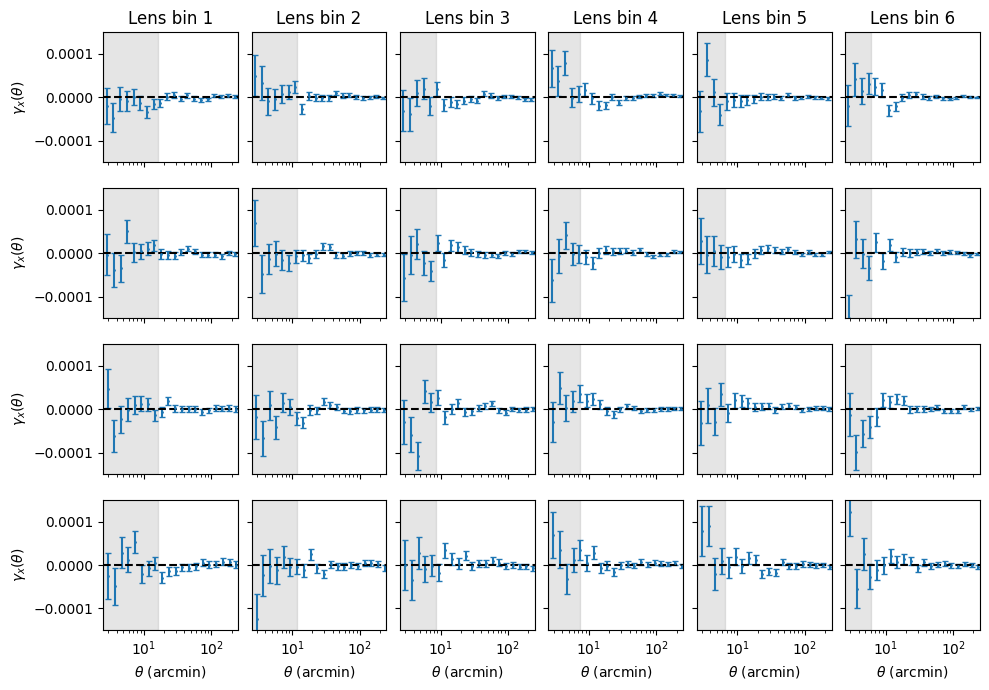

In [9]:
fig, ax = plt.subplots(4,6, figsize = (10,7), sharex = True, sharey = True)



shift = [0, 0.02, 0.04, 0.06]

for l in range(6):
    for s in range(4):
        fid  = np.loadtxt('./2024-09-16_fid/gammax/gammax_l{0}_s{1}.txt'.format(l+1, s+1))
        ax[s, l].errorbar(fid[:,0]+fid[:,0]*shift[s], fid[:,1], err_th.reshape(6,4,26)[l][s], label = 'Source bin {}'.format(s+1), fmt='o', capsize=2, capthick=1, markersize = 1)
        ax[s, l].axhline(y=0, linestyle = '--', color = 'black')
        minlim = -0.00015
        maxlim = 0.00015
        ax[s, l].fill([2.5,2.5,scale_cuts[l],scale_cuts[l]],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        ax[s, l].fill([250,250,1000,1000],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        
        ax[s, l].set_ylim(minlim, maxlim)
        ax[s, l].set_xlim(2.5, 250)
        ax[s, l].set_xscale('log')
        
        ax[3, l].set_xlabel(r'$\theta$ (arcmin)')
        ax[s, 0].set_ylabel(r'$\gamma_x(\theta)$')
        ax[0, l].set_title('Lens bin {}'.format(l+1))

    # ax[2,1].legend()
# plt.suptitle('Maglim - METADETECT')
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.1)
plt.savefig('./plots/gammax_250.pdf')


### do the same thing but bin by bin with jck 

In [10]:
# all scales 
chi2_gammax = np.zeros((6,4))
pvalue_gammax = np.zeros((6,4))
chi2_gammax_ = []

for l in range(6):
    for s in range(4):
        cov_ = np.loadtxt('./2024-09-16_fid/Jackknife/gammat_covariance/cov_gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        asd = np.loadtxt('./2024-09-16_fid/gammax/gammax_l{0}_s{1}.txt'.format(l+1, s+1))
        gammax = asd[:,1]  
        theta = asd[:,0]

    
        gammax_cov_INV = np.linalg.inv(cov_)
        chi2_gammax[l,s] = gammax.T @ gammax_cov_INV @ gammax
        chi2_gammax_.append(gammax.T @ gammax_cov_INV @ gammax)
        print (chi2_gammax[l,s])

        p_value = 1 - chi2.cdf(chi2_gammax[l,s], len(gammax))
        pvalue_gammax[l,s] = p_value
        print (p_value)

24.422292062746003
0.551831731479683
25.23017473757087
0.5059777922741829
18.01675545702016
0.8751629724451335
17.713192205186033
0.8859575982252171
20.54036684369233
0.7652822491079352
18.11512025576169
0.8715449715628298
18.981662022285207
0.8372030016710429
16.23364819324827
0.9304154676045522
17.219998677024403
0.9022861407309105
19.432027094412735
0.8176805429387937
30.850886757064394
0.23386964681957323
11.002950806262005
0.9955394639516982
34.17671503382473
0.13063252819632865
18.264573510145503
0.8659364605762017
13.677686296834136
0.9770072163539126
14.403029726682284
0.9672988291229728
11.989034444335593
0.9912341080197568
12.984979888505524
0.9841070087691834
12.975158914322407
0.9841939379863216
24.404776330792718
0.5528315876427004
22.116041424673323
0.6823310308613966
24.563112409071845
0.5437992621316878
26.524538275674196
0.43458270776711083
15.313550643789188
0.9513269743894733


In [11]:
# scales \theta < 250 

pvalue_gammax = np.zeros((6,4))
chi2_gammax_sc = np.zeros((6,4))
chi2_gammax = []

for l in range(6):
    for s in range(4):
        cov_ = np.loadtxt('./2024-09-16_fid/Jackknife/gammat_covariance/cov_gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        asd = np.loadtxt('./2024-09-16_fid/gammax/gammax_l{0}_s{1}.txt'.format(l+1, s+1))
        gammax = asd[:,1]  
        theta = asd[:,0]

        mask =  (theta<= 250.)
        gammax_masked = gammax[mask]
        print (len(gammax_masked))

        cov_masked = cov_[mask,:][:,mask]

        gammax_cov_INV = np.linalg.inv(cov_masked)
        chi2_gammax_sc[l,s] = gammax_masked.T @ gammax_cov_INV @ gammax_masked
        chi2_gammax.append(chi2_gammax_sc[l,s])
        print (chi2_gammax_sc[l,s])

        p_value = 1 - chi2.cdf(chi2_gammax_sc[l,s], len(gammax_masked))
        pvalue_gammax[l,s] = p_value
        print (p_value)
        

20
17.56894226175339
0.6157806828496097
20
18.805740074784282
0.5344834972471234
20
16.72715560487647
0.6706128643135248
20
16.619461961315533
0.6775272524991163
20
16.208206143653282
0.7036263533642023
20
13.256386524196362
0.866114546606031
20
16.13165822259967
0.708423519142634
20
15.306292482053358
0.7586214108379103
20
16.667982886772307
0.674415675537157
20
16.17361497618142
0.7057967117886068
20
28.888251831522666
0.08998313213307996
20
10.154611298453542
0.9652809466077612
20
30.583369919071288
0.06093644773576601
20
15.19978034013789
0.7648642456278726
20
13.036964243096605
0.8757924486493316
20
13.796202955534207
0.8406767196624888
20
11.45838121847694
0.9334585446026418
20
11.78004824478958
0.9234384810493959
20
12.112454906306453
0.9121509661898167
20
22.24531485826408
0.32734894458747577
20
19.441501996904684
0.4933166643899989
20
21.343678403095677
0.37715795100259686
20
23.95260004822138
0.24446882926967117
20
14.440953043462962
0.807453679861986


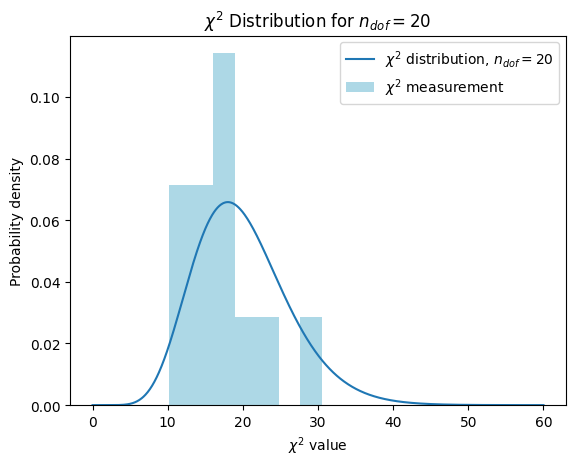

In [12]:
n_dof = 20

# Create an array of x values (chi-squared values)
x = np.linspace(0, 60, 1000)  # Adjust the range as needed

# Compute the chi-squared probability density function (PDF)
chi2_pdf = chi2.pdf(x, df=n_dof)

# Plot the chi-squared distribution
plt.plot(x, chi2_pdf, label=r'$\chi^2$ distribution, $n_{dof} = 20$')

# Mark the expected peak (n_dof - 2)
# plt.axvline(n_dof - 2, color='r', linestyle='--', label=f'Peak ~ {n_dof - 2}')
plt.hist(chi2_gammax, bins = 7, density = True, color = 'lightblue', label = r'$\chi^2$ measurement')
# Add labels and legend
plt.xlabel(r'$\chi^2$ value')
plt.ylabel('Probability density')
plt.title(r'$\chi^2$ Distribution for $n_{dof} = 20$')
plt.legend()
plt.savefig('./plots/gammax_chi2_250.png')

## 2) tangential shear around rnd points

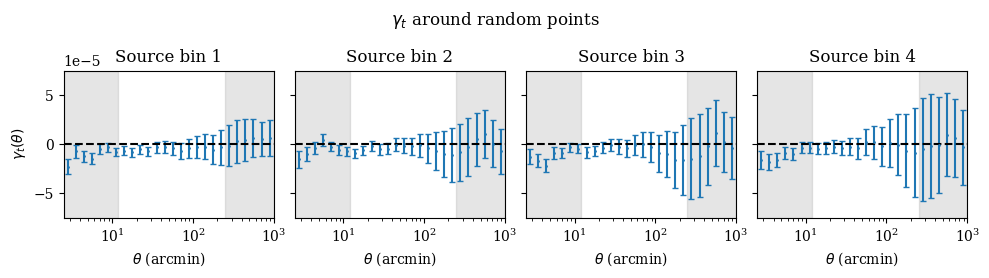

In [60]:
fig, ax = plt.subplots(1,4, figsize = (10,3), sharex = True, sharey = True)

for s in range(4):
    l = 1
    fid  = np.loadtxt('./2024-09-16_rnd2/gammat/gammat_l1_s{}.txt'.format(s+1))
    err  = np.loadtxt('./2024-09-16_rnd2/Jackknife/gammat_covariance/err_gammat_l1_s{}.txt'.format(s+1))
    # print (fid)
    # ax[l//2, l%2].errorbar(angles+angles*shift[s], gammax[:,1], err.reshape(6,4,20)[l][s], label = 'Source bin {}'.format(s+1), fmt='o', capsize=2, capthick=2)
    ax[s].errorbar(fid[:,0], fid[:,1], err[:,1], label = 'Source bin {}'.format(s+1), fmt='o', capsize=2, capthick=1, markersize = 1)
    ax[s].axhline(y=0, linestyle = '--', color = 'black')
    minlim = -0.000075
    maxlim = 0.000075
    ax[s].fill([2.5,2.5,scale_cuts[l],scale_cuts[l]],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
    ax[s].fill([250,250,1000,1000],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)

    ax[s].set_ylim(minlim, maxlim)
    ax[s].set_xlim(2.5, 1000)
    ax[s].set_xscale('log')

    ax[s].set_xlabel(r'$\theta$ (arcmin)')
    ax[0].set_ylabel(r'$\gamma_t(\theta)$')
    ax[s].set_title('Source bin {}'.format(s+1))

    # ax[2,1].legend()
plt.suptitle(r'$\gamma_t$ around random points', y = 0.91)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.1)
plt.savefig('./plots/random_points_final.pdf')

In [61]:

for s in range(4):
    cov_ = np.loadtxt('./2024-09-16_rnd2/Jackknife/gammat_covariance/cov_gammat_l1_s{0}.txt'.format(s+1))
    gammat = np.loadtxt('./2024-09-16_rnd2/gammat/gammat_l1_s{0}.txt'.format(s+1))[:,1]   
    gammat_cov_INV = np.linalg.inv(cov_)
    chi2_gammat = gammat.T @ gammat_cov_INV @ gammat
    print (chi2_gammat/26)
    # print (np.diagonal(cov_))


1.1158129209832763
0.6077318070298817
0.8229986288769852
0.7133075887236335


In [62]:
for s in range(4):
    print (s)
    cov_ = np.loadtxt('./2024-09-16_rnd2/Jackknife/gammat_covariance/cov_gammat_l1_s{0}.txt'.format(s+1))
    err_ = np.loadtxt('./2024-09-16_rnd2/Jackknife/gammat_covariance/err_gammat_l1_s{0}.txt'.format(s+1))
    print (np.sqrt(np.diagonal(cov_)))
    print (err_[:,1])

0
[7.48632136e-06 6.81298497e-06 5.69488098e-06 5.20493686e-06
 5.04019936e-06 4.59338425e-06 4.37422788e-06 4.44592726e-06
 4.65175736e-06 4.63241469e-06 4.79722926e-06 5.27100390e-06
 6.02700101e-06 6.81699866e-06 8.01505054e-06 9.38787844e-06
 1.09278942e-05 1.26672447e-05 1.48736704e-05 1.80613565e-05
 2.09117423e-05 2.20559557e-05 2.13776426e-05 1.90069350e-05
 1.75578653e-05 1.83450305e-05]
[7.48632136e-06 6.81298497e-06 5.69488098e-06 5.20493686e-06
 5.04019936e-06 4.59338425e-06 4.37422788e-06 4.44592726e-06
 4.65175736e-06 4.63241469e-06 4.79722926e-06 5.27100390e-06
 6.02700101e-06 6.81699866e-06 8.01505054e-06 9.38787844e-06
 1.09278942e-05 1.26672447e-05 1.48736704e-05 1.80613565e-05
 2.09117423e-05 2.20559557e-05 2.13776426e-05 1.90069350e-05
 1.75578653e-05 1.83450305e-05]
1
[8.49760995e-06 6.96639436e-06 6.00764440e-06 5.80859089e-06
 4.73877365e-06 4.90913617e-06 4.44548214e-06 4.45780038e-06
 4.55579809e-06 4.99194594e-06 5.31870034e-06 5.66209640e-06
 6.75246394e-06 7

Now apply scale cuts

In [63]:

for s in range(4):
    cov_ = np.loadtxt('./2024-09-16_rnd2/Jackknife/gammat_covariance/cov_gammat_l1_s{0}.txt'.format(s+1))
    asd = np.loadtxt('./2024-09-16_rnd2/gammat/gammat_l1_s{0}.txt'.format(s+1))  
    gammat = asd[:,1]  
    theta = asd[:,0]
    # print (gammat)

    mask = (theta>scale_cuts[l]) & (theta<= 250.)
    gammat_masked = gammat[mask]
    print (len(gammat_masked))

    cov_masked = cov_[mask,:][:,mask]
    # print (cov_masked.shape)
    # print (np.diagonal(cov_masked))
    # print (np.linalg.cond(cov_masked))
    gammat_cov_INV = np.linalg.inv(cov_masked)
    chi2_gammat_sc = gammat_masked.T @ gammat_cov_INV @ gammat_masked
    
    print (chi2_gammat_sc, chi2_gammat_sc/len(gammat_masked))
    
    p_value = 1 - chi2.cdf(chi2_gammat_sc, len(gammat_masked))
    print (p_value)

13
8.935539557220409 0.6873491967092622
0.7777943312069799
13
7.397599110839436 0.5690460854491873
0.880516515379473
13
6.571114346780235 0.5054703343677104
0.9228818750924043
13
5.339731799299033 0.41074859994607943
0.96693332880403


## 3) PSF residuals

### by bin

In [14]:
! cp -r /global/cfs/cdirs/des/giannini/ggl/2024-09-16_psf_shape .

In [15]:
! cp -r /global/cfs/cdirs/des/giannini/ggl/2024-09-16_psf_size .

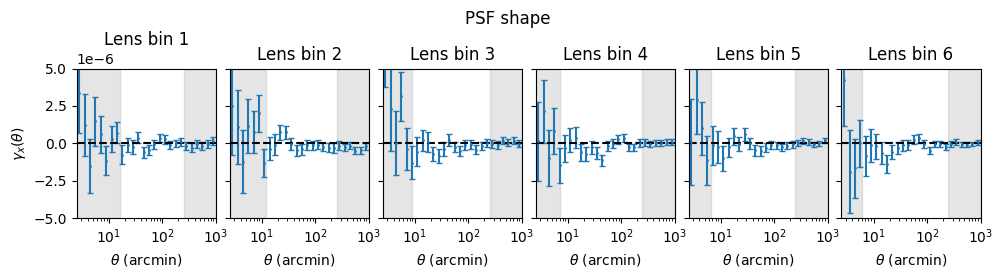

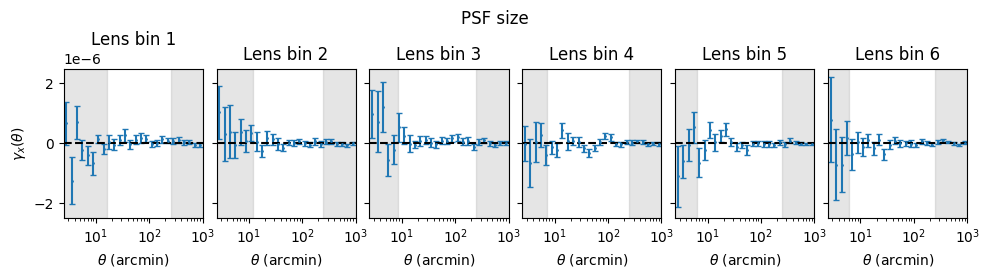

In [16]:
fig, ax = plt.subplots(1,6, figsize = (10,3), sharex = True, sharey = True)

for l in range(6):
    for s in range(1):
        fid  = np.loadtxt('./2024-09-16_psf_shape/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        err = np.loadtxt('./2024-09-16_psf_shape/Jackknife/gammat_covariance/err_gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        # print (fid)
        # ax[l//2, l%2].errorbar(angles+angles*shift[s], gammax[:,1], err.reshape(6,4,20)[l][s], label = 'Source bin {}'.format(s+1), fmt='o', capsize=2, capthick=2)
        ax[l].errorbar(fid[:,0], fid[:,1], err[:,1], label = 'Source bin {}'.format(s+1), fmt='o', capsize=2, capthick=1, markersize = 1)
        ax[l].axhline(y=0, linestyle = '--', color = 'black')
        minlim = -0.000005
        maxlim = 0.000005
        ax[l].fill([2.5,2.5,scale_cuts[l],scale_cuts[l]],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        ax[l].fill([250,250,1000,1000],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        
        ax[l].set_ylim(minlim, maxlim)
        ax[l].set_xlim(2.5, 1000)
        ax[l].set_xscale('log')
        
        ax[l].set_xlabel(r'$\theta$ (arcmin)')
        ax[0].set_ylabel(r'$\gamma_x(\theta)$')
        ax[l].set_title('Lens bin {}'.format(l+1))

    # ax[2,1].legend()
plt.suptitle('PSF shape', y= 0.91)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.1)
plt.savefig('./plots/psf_shape.png')



fig, ax = plt.subplots(1,6, figsize = (10,3), sharex = True, sharey = True)

for l in range(6):
    for s in range(1):
        fid  = np.loadtxt('./2024-09-16_psf_size/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        err = np.loadtxt('./2024-09-16_psf_size/Jackknife/gammat_covariance/err_gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        # print (fid)
        # ax[l//2, l%2].errorbar(angles+angles*shift[s], gammax[:,1], err.reshape(6,4,20)[l][s], label = 'Source bin {}'.format(s+1), fmt='o', capsize=2, capthick=2)
        ax[l].errorbar(fid[:,0], fid[:,1], err[:,1], label = 'Source bin {}'.format(s+1), fmt='o', capsize=2, capthick=1, markersize = 1)
        ax[l].axhline(y=0, linestyle = '--', color = 'black')
        minlim = -0.0000025
        maxlim = 0.0000025
        ax[l].fill([2.5,2.5,scale_cuts[l],scale_cuts[l]],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        ax[l].fill([250,250,1000,1000],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        
        ax[l].set_ylim(minlim, maxlim)
        ax[l].set_xlim(2.5, 1000)
        ax[l].set_xscale('log')
        
        ax[l].set_xlabel(r'$\theta$ (arcmin)')
        ax[0].set_ylabel(r'$\gamma_x(\theta)$')
        ax[l].set_title('Lens bin {}'.format(l+1))

    # ax[2,1].legend()
plt.suptitle('PSF size', y = 0.91)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.1)
plt.savefig('./plots/psf_size.png')


In [17]:

for l in range(6):
    cov_ = np.loadtxt('./2024-09-16_psf_shape/Jackknife/gammat_covariance/cov_gammat_l{0}_s1.txt'.format(l+1))
    gammat = np.loadtxt('./2024-09-16_psf_shape/gammat_bf_rp/gammat_l{0}_s1.txt'.format(l+1))[:,1]   
    gammat_cov_INV = np.linalg.inv(cov_)
    chi2_gammat = gammat.T @ gammat_cov_INV @ gammat
    print (chi2_gammat/26)

1.2114490117679535
0.8668121473867465
1.3625912190571816
1.1049204838402304
0.7114646992620125
0.836901032534535


Now apply scale cuts

In [18]:

for l in range(6):
    cov_ = np.loadtxt('./2024-09-16_psf_shape/Jackknife/gammat_covariance/cov_gammat_l{0}_s1.txt'.format(l+1))
    asd = np.loadtxt('./2024-09-16_psf_shape/gammat_bf_rp/gammat_l{0}_s1.txt'.format(l+1))
    gammat = asd[:,1]  
    theta = asd[:,0]
    
    mask = (theta>scale_cuts[l]) & (theta<= 250.)
    gammat_masked = gammat[mask]
    print (len(gammat_masked))

    cov_masked = cov_[mask,:][:,mask]
    
    gammat_cov_INV = np.linalg.inv(cov_masked)
    chi2_gammat_sc = gammat_masked.T @ gammat_cov_INV @ gammat_masked
    
    print (chi2_gammat_sc, chi2_gammat_sc/len(gammat_masked))
    
    p_value = 1 - chi2.cdf(chi2_gammat_sc, len(gammat_masked))
    print (p_value)

12
14.7623040902865 1.230192007523875
0.2546934908403473
13
7.7826837759481755 0.5986679827652442
0.8574640665478113
15
16.191908817248432 1.0794605878165622
0.36941322741929117
15
22.777485922399073 1.5184990614932716
0.08897986755148057
16
11.681287467703672 0.7300804667314795
0.7656127348545898
16
15.12108807084478 0.9450680044277987
0.5157883478603518


In [19]:
# no scale cuts
for l in range(6):
    cov_ = np.loadtxt('./2024-09-16_psf_size/Jackknife/gammat_covariance/cov_gammat_l{0}_s1.txt'.format(l+1))
    gammat = np.loadtxt('./2024-09-16_psf_size/gammat_bf_rp/gammat_l{0}_s1.txt'.format(l+1))[:,1]   
    gammat_cov_INV = np.linalg.inv(cov_)
    chi2_gammat = gammat.T @ gammat_cov_INV @ gammat
    print (chi2_gammat/26)

0.9083050090529106
0.8906272537221951
1.0532889468536328
1.4087245589853823
0.9485435608129068
0.6713309959499241


Now apply scale cuts

In [20]:

for l in range(6):
    cov_ = np.loadtxt('./2024-09-16_psf_size/Jackknife/gammat_covariance/cov_gammat_l{0}_s1.txt'.format(l+1))
    asd = np.loadtxt('./2024-09-16_psf_size/gammat_bf_rp/gammat_l{0}_s1.txt'.format(l+1))
    gammat = asd[:,1]  
    theta = asd[:,0]
    
    mask = (theta>scale_cuts[l]) & (theta<= 250.)
    gammat_masked = gammat[mask]
    print (len(gammat_masked))

    cov_masked = cov_[mask,:][:,mask]
    
    gammat_cov_INV = np.linalg.inv(cov_masked)
    chi2_gammat_sc = gammat_masked.T @ gammat_cov_INV @ gammat_masked
    
    print (chi2_gammat_sc, chi2_gammat_sc/len(gammat_masked))
    
    p_value = 1 - chi2.cdf(chi2_gammat_sc, len(gammat_masked))
    print (p_value)

12
7.011954607551267 0.5843295506292723
0.8568225303954689
13
12.381676444605576 0.9524366495850443
0.49662202682842416
15
17.075613744256202 1.1383742496170801
0.3143643451039533
15
18.612722167407654 1.2408481444938435
0.23182274449458984
16
15.114212999721758 0.9446383124826099
0.5162898129195684
16
10.330146590858043 0.6456341619286277
0.8488279623435355


### by band

In [21]:
scale_cuts_low = np.array([16.112, 11.904, 8.675, 7.251, 6.465, 6.023])
scale_cuts_high = 250

In [46]:
#load in shape resids
shape_dirs = ["./psf_residuals_Oct24/output_by_bin/shape_r/gammat_bf_rp",
              "./psf_residuals_Oct24/output_by_bin/shape_i/gammat_bf_rp",
              "./psf_residuals_Oct24/output_by_bin/shape_z/gammat_bf_rp"]
shape_resid = [[],[],[]]
for b in range(3):
    ang = []
    #iterate over lens and source bins
    for l in range(6):
        for s in range(1):
            asd = np.loadtxt(shape_dirs[b] + '/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
            shape_resid[b].append(asd[:,1])
            ang.append(asd[:,0])
    shape_resid[b] = np.array(shape_resid[b])
    ang = np.array(ang)
    # print(shape_resid[b])
    #print(ang)

#and jackknife covariance
gammat_cov_dirs = ["./psf_residuals_Oct24/output_by_bin/shape_r/Jackknife/gammat_covariance",
                   "./psf_residuals_Oct24/output_by_bin/shape_i/Jackknife/gammat_covariance",
                   "./psf_residuals_Oct24/output_by_bin/shape_z/Jackknife/gammat_covariance"]
gammat_err = [[],[],[]]
for b in range(3):
    #iterate over lens and source bins
    for l in range(6):
        for s in range(1):
            asd = np.loadtxt(gammat_cov_dirs[b] + '/cov_gammat_l{0}_s{1}.txt'.format(l+1, s+1))
            gammat_err[b].append(np.sqrt(np.diag(asd)))
    gammat_err[b] = np.array(gammat_err[b])
    #print(gammat_err[b])
    
print(ang)

[[  2.80504614   3.53134386   4.44569853   5.59680285   7.04595733
    8.87033473  11.1670898   14.05853313  17.69864461  22.28127345
   28.05046136  35.31343862  44.45698525  55.96802846  70.45957328
   88.70334731 111.67089804 140.5853313  176.9864461  222.81273453
  280.50461358 353.13438616 444.56985251 559.68028464 704.59573282
  887.03347308]
 [  2.80504614   3.53134386   4.44569853   5.59680285   7.04595733
    8.87033473  11.1670898   14.05853313  17.69864461  22.28127345
   28.05046136  35.31343862  44.45698525  55.96802846  70.45957328
   88.70334731 111.67089804 140.5853313  176.9864461  222.81273453
  280.50461358 353.13438616 444.56985251 559.68028464 704.59573282
  887.03347308]
 [  2.80504614   3.53134386   4.44569853   5.59680285   7.04595733
    8.87033473  11.1670898   14.05853313  17.69864461  22.28127345
   28.05046136  35.31343862  44.45698525  55.96802846  70.45957328
   88.70334731 111.67089804 140.5853313  176.9864461  222.81273453
  280.50461358 353.13438616 44

In [47]:
#calculate chi2
shape_chi2 = np.zeros([3,6,1])
shape_chi2_cuts = np.zeros([3,6,1])
shape_chi2_cuts_red = np.zeros([3,6,1])
for band in range(3):
    for t in range(6):
        for b in range(1):
            shape_chi2[band,t,b] = np.sum(shape_resid[band].reshape(6,1,26)[t][b]**2 / gammat_err[band].reshape(6,1,26)[t][b]**2)
            gt_cuts = []
            gt_err_cuts = []
            for a in range(26):
                # if scale_cuts_low[t] < ang.reshape(6,1,26)[t][b][a] < scale_cuts_high:
                if ang.reshape(6,1,26)[t][b][a] < scale_cuts_high:
                    gt_cuts.append(shape_resid[band].reshape(6,1,26)[t][b][a])
                    gt_err_cuts.append(gammat_err[band].reshape(6,1,26)[t][b][a])
            #print(len(gt_cuts))
            shape_chi2_cuts[band,t,b] = np.sum(np.array(gt_cuts)**2 / np.array(gt_err_cuts)**2)
            shape_chi2_cuts_red[band,t,b] = shape_chi2_cuts[band,t,b] / len(gt_cuts)
            
        
#print(chi2)
print('shape')
print(shape_chi2_cuts)
# print(shape_chi2_cuts_red[:,:,0])

shape
[[[23.65666651]
  [11.31589963]
  [29.94474534]
  [29.11679504]
  [14.66662968]
  [ 7.05016827]]

 [[18.61707663]
  [20.66828726]
  [12.2487639 ]
  [17.20292794]
  [16.89838527]
  [17.58004783]]

 [[25.43885332]
  [24.84052231]
  [14.91531582]
  [16.85006613]
  [11.22873701]
  [23.53001332]]]


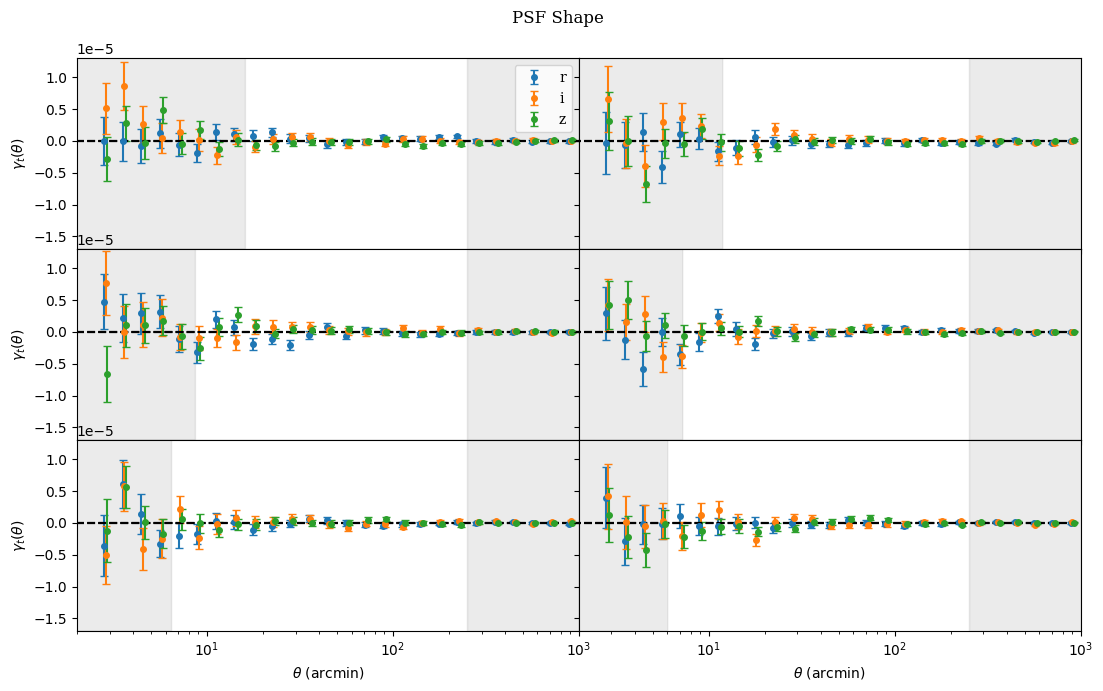

In [25]:
#plot resids
fig, ax = plt.subplots(3,2, figsize = (11, 7), sharex = True, sharey = True)
ccc = ['dodgerblue','darkorange', 'forestgreen', 'crimson']
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.family'] = 'serif'  # Adjust font family

bands = ["r","i","z"]
zerox = [0,1000]
zeroy = [0,0]

for band in range(3):
    for t in range(6):
        for b in range(1):
            ttheta = shape_resid[band].reshape(6,1,26)[t][b]
            ttheta_err = gammat_err[band].reshape(6,1,26)[t][b]
            ax[t//2, t%2].errorbar(ang.reshape(6,1,26)[t][b] + ang.reshape(6,1,26)[t][b]*0.02*band, ttheta, ttheta_err, 
                                label = bands[band], fmt='o', markersize = 4, capsize=3, capthick=1)

        ax[t//2, t%2].set_xscale('log')
        #ax[t//2, t%2].set_yscale('log')
        ax[t//2, t%2].set_ylim(-0.000017, 0.000013)
        ax[t//2, t%2].set_xlim(2, 1000)
        ax[2, t%2].set_xlabel(r'$\theta$ (arcmin)')
        ax[t//2, 0].set_ylabel(r'$\gamma_t(\theta)$')
        # ax[t//2, t%2].set_title('Lens bin {}'.format(t+1))
        #ax[t//2, t%2].set_yticks([])
        #ax[t//2, t%2].text(100, 0.003, 'Lens bin {}'.format(t+1), va='center', rotation='horizontal')
        ax[t//2, t%2].fill([0,0,scale_cuts_low[t],scale_cuts_low[t]],[-0.000017,  0.000013,-0.000017, 0.000013],  color='gray', alpha=0.05)
        ax[t//2, t%2].fill([scale_cuts_high,scale_cuts_high,1000,1000,],[0.000013,  -0.000017,-0.000017, 0.000013],  color='gray', alpha=0.05)
        ax[0,0].legend()

        ax[t//2, t%2].plot(zerox, zeroy, color="black", linestyle="--")
    
plt.suptitle('PSF Shape')
plt.tight_layout()
plt.subplots_adjust(hspace=0., wspace=0.)
plt.savefig("./plots/psf_shape_by_bin.pdf")

In [48]:
#load in size resids
size_dirs = ["./psf_residuals_Oct24/output_by_bin/size_r/gammat_bf_rp",
             "./psf_residuals_Oct24/output_by_bin/size_i/gammat_bf_rp",
             "./psf_residuals_Oct24/output_by_bin/size_z/gammat_bf_rp"]
size_resid = [[],[],[],[]]
for b in range(3):
    ang = []
    #iterate over lens and source bins
    for l in range(6):
        for s in range(1):
            asd = np.loadtxt(size_dirs[b] + '/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
            size_resid[b].append(asd[:,1])
            ang.append(asd[:,0])
    size_resid[b] = np.array(size_resid[b])
    ang = np.array(ang)
    #print(shape_resid[b])
    #print(ang)

#and jackknife covariance
gammat_cov_dirs = ["./psf_residuals_Oct24/output_by_bin/size_r/Jackknife/gammat_covariance",
                   "./psf_residuals_Oct24/output_by_bin/size_i/Jackknife/gammat_covariance",
                   "./psf_residuals_Oct24/output_by_bin/size_z/Jackknife/gammat_covariance"]
gammat_err = [[],[],[],[]]
for b in range(3):
    #iterate over lens and source bins
    for l in range(6):
        for s in range(1):
            asd = np.loadtxt(gammat_cov_dirs[b] + '/cov_gammat_l{0}_s{1}.txt'.format(l+1, s+1))
            gammat_err[b].append(np.sqrt(np.diag(asd)))
    gammat_err[b] = np.array(gammat_err[b])
    #print(gammat_err[b])
    
#print(size_resid[3])

/tmp/ipykernel_804330/2412411175.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2,0].legend()


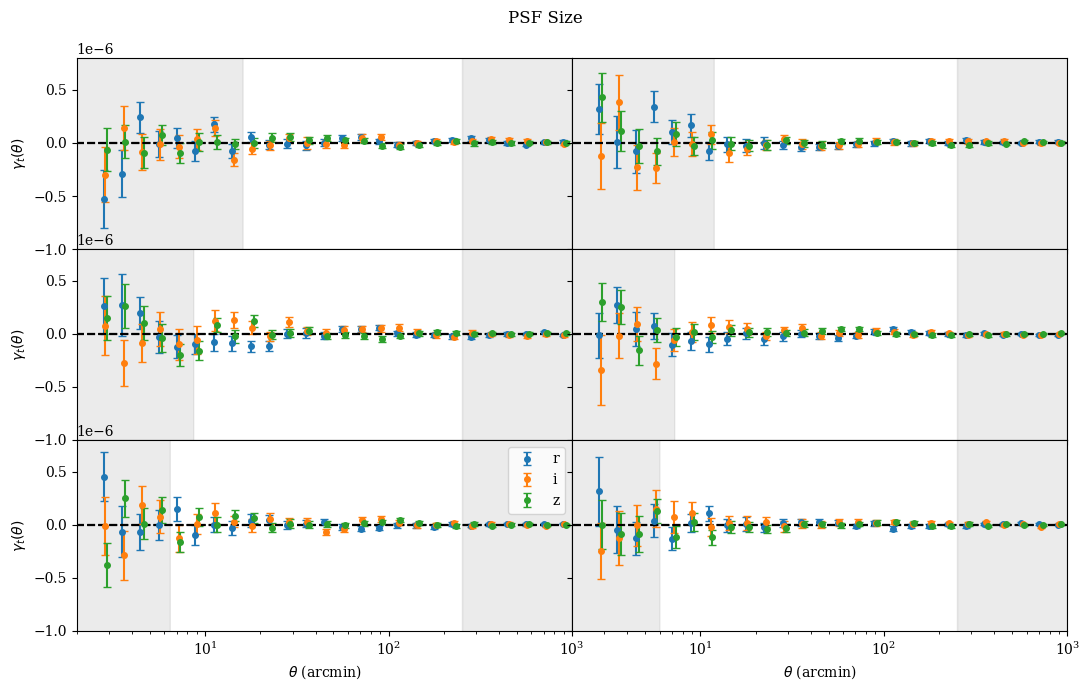

In [49]:
#plot resids
fig, ax = plt.subplots(3,2, figsize = (11, 7), sharex = True, sharey = True)
ccc = ['dodgerblue','darkorange', 'forestgreen', 'crimson']
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.family'] = 'serif'  # Adjust font family

bands = ["r","i","z"]
zerox = [0,1000]
zeroy = [0,0]

for band in range(3):
    for t in range(6):
        for b in range(1):
            ttheta = size_resid[band].reshape(6,1,26)[t][b]
            ttheta_err = gammat_err[band].reshape(6,1,26)[t][b]
            ax[t//2, t%2].errorbar(ang.reshape(6,1,26)[t][b] + ang.reshape(6,1,26)[t][b]*0.02*band, ttheta, ttheta_err, 
                                label = bands[band], fmt='o', markersize = 4, capsize=3, capthick=1)

        ax[t//2, t%2].set_xscale('log')
        #ax[t//2, t%2].set_yscale('log')
        ax[t//2, t%2].set_ylim(-0.000001, 0.0000008)
        ax[t//2, t%2].set_xlim(2, 1000)
        ax[2, t%2].set_xlabel(r'$\theta$ (arcmin)')
        ax[t//2, 0].set_ylabel(r'$\gamma_t(\theta)$')
        # ax[t//2, t%2].set_title('Lens bin {}'.format(t+1))
        #ax[t//2, t%2].set_yticks([])
        #ax[t//2, t%2].text(100, 0.003, 'Lens bin {}'.format(t+1), va='center', rotation='horizontal')
        ax[t//2, t%2].fill([0,0,scale_cuts_low[t],scale_cuts_low[t]],[-0.00001,  0.00001,-0.00001, 0.00001],  color='gray', alpha=0.05)
        ax[t//2, t%2].fill([scale_cuts_high,scale_cuts_high,1000,1000,],[0.00001,  -0.00001,-0.00001, 0.00001],  color='gray', alpha=0.05)
        ax[2,0].legend()

        ax[t//2, t%2].plot(zerox, zeroy, color="black", linestyle="--")
    
plt.suptitle('PSF Size')
plt.tight_layout()
plt.subplots_adjust(hspace=0., wspace=0.)
plt.savefig("./plots/psf_size_by_bin.pdf", dpi=200)

In [50]:




#calculate chi2
size_chi2 = np.zeros([3,6,1])
size_chi2_cuts = np.zeros([3,6,1])
size_chi2_cuts_red = np.zeros([3,6,1])
for band in range(3):
    for t in range(6):
        for b in range(1):
            size_chi2[band,t,b] = np.sum(size_resid[band].reshape(6,1,26)[t][b]**2 / gammat_err[band].reshape(6,1,26)[t][b]**2)
            gt_cuts = []
            gt_err_cuts = []
            for a in range(26):
                # if scale_cuts_low[t] < ang.reshape(6,1,26)[t][b][a] < scale_cuts_high:
                if ang.reshape(6,1,26)[t][b][a] < scale_cuts_high:
                    gt_cuts.append(size_resid[band].reshape(6,1,26)[t][b][a])
                    gt_err_cuts.append(gammat_err[band].reshape(6,1,26)[t][b][a])
            #print(len(gt_cuts))
            size_chi2_cuts[band,t,b] = np.sum(np.array(gt_cuts)**2 / np.array(gt_err_cuts)**2)
            size_chi2_cuts_red[band,t,b] = size_chi2_cuts[band,t,b] / len(gt_cuts)
        
#print(chi2)
print ('size')
print(size_chi2_cuts)
#print(size_chi2_cuts_red)


size
[[[28.71986648]
  [17.54214885]
  [30.95586588]
  [17.33831843]
  [15.90936443]
  [12.60324435]]

 [[20.76402272]
  [12.87212532]
  [27.57126692]
  [14.73534233]
  [20.08938603]
  [ 9.73390803]]

 [[17.06945573]
  [ 9.22948825]
  [23.23653312]
  [18.65117869]
  [22.53289506]
  [14.35547708]]]


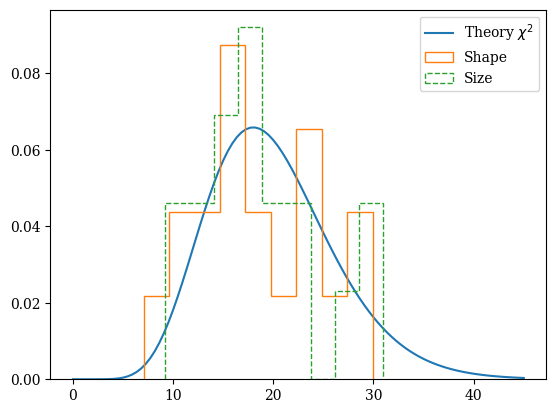

SHAPE
Full Range:
dof = 450, chi2 = 393.4465538134237
Scale Cuts:
dof = 243, chi2 = 335.76990122180734

SIZE
Full Range:
dof = 450, chi2 = 404.1668729222512
Scale Cuts:
dof = 243, chi2 = 333.90988768495


<Figure size 640x480 with 0 Axes>

In [57]:
#Chi2 distribution plot
x = np.linspace(0, 45, 100)
chi2_theory = chi2.pdf(x, 20)
plt.plot(x, chi2_theory)
plt.hist(shape_chi2_cuts.reshape(18), bins = 9, density=True, histtype="step")
plt.hist(size_chi2_cuts.reshape(18),  bins = 9, density=True, histtype="step", linestyle="--")
plt.legend(["Theory $\chi^2$", "Shape", "Size"])
plt.show()

print("SHAPE")
print("Full Range:")
print("dof = 450, chi2 =",np.sum(shape_chi2))
print("Scale Cuts:")
print("dof = 243, chi2 =",np.sum(shape_chi2_cuts))
print()
print("SIZE")
print("Full Range:")
print("dof = 450, chi2 =",np.sum(size_chi2))
print("Scale Cuts:")
print("dof = 243, chi2 =",np.sum(size_chi2_cuts))

plt.tight_layout()
plt.subplots_adjust(hspace=0., wspace=0.)
plt.savefig("./plots/psf_chi2_250only.pdf", dpi=200)

## 4) scale dependent response

In [92]:
#Load all the data

#Datavector
gammat_dir = "./fullscale_070624/gammat_bf_rp"
gammat = []
#iterate over source bins
for l in range(6):
    for s in range(4):
        asd = np.loadtxt(gammat_dir + '/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        gammat.append(asd[:,1])
gammat = np.array(gammat)
gammat = gammat.reshape((6,4,26))     #THIS IS UNBLINDED SO DO NOT PLOT IT
print(gammat.shape)

#Mean response per source bin
meanR_dir = "./response_tests"
meanR = []
for s in range(4):
    asd = np.loadtxt(meanR_dir + "/Response_diag_bin{0}.txt".format(s))
    meanR.append(asd[0])
meanR = np.array(meanR)
print(meanR)

#Scale-dependant response
scaleR_dir = "./response_tests/scale-dependent_Oct24/responses"
scaleR = []
for s in range(4):
    asd = np.loadtxt(scaleR_dir + "/Rmean_s{0}.txt".format(s+1))
    scaleR.append(asd)
scaleR = np.array(scaleR)
print(scaleR.shape)

#Angular scales for plotting
theta = np.loadtxt(gammat_dir + '/gammat_l1_s1.txt')[:,0]
scale_cuts_low = np.array([16.808, 11.297, 8.809, 7.385, 6.613, 6.169])
scale_cuts_high = 250

(6, 4, 26)
[0.85712719 0.86775723 0.81974834 0.69158139]
(4, 26)


In [93]:
#This cell corrects the dv if it was computed using different responses than those loaded as meanR

oldR_dir = "./response_tests"
oldR = []
for s in range(4):
    asd = np.loadtxt(oldR_dir + "/response_zbin{0}.txt".format(s+1))
    oldR.append(asd[0])
oldR = np.array(oldR)
print(oldR)   #Currently these are identical to the new values, despite being calculated with an older catalogue

#Now correct the dv
for s in range(4):
    gammat[:,s,:] = gammat[:,s,:] * oldR[s] / meanR[s]

[0.86256582 0.85947977 0.81663898 0.68256039]


In [94]:
#Construct test dv by swapping mean Rs for scale-dependant Rs and calculate the residual dv

gammat_scale = np.zeros((6,4,26))
resid = np.zeros((6,4,26))
for l in range(6):
    for s in range(4):
        for a in range(26):
            gammat_scale[l,s,a] = gammat[l,s,a] * meanR[s] / scaleR[s,a]
            resid[l,s,a] = gammat_scale[l,s,a] - gammat[l,s,a]
            
#print(resid)

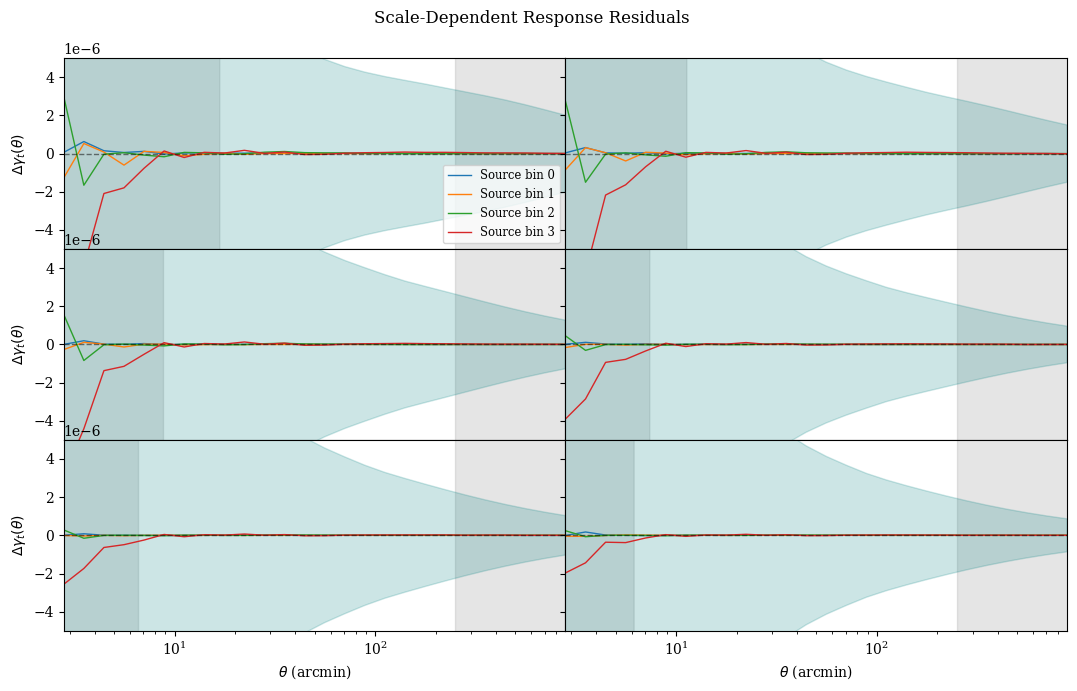

In [97]:
#Plot resids

fig, ax = plt.subplots(3,2, figsize = (11, 7), sharex = True, sharey = True)
ccc = ['dodgerblue','darkorange', 'forestgreen', 'crimson']
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.family'] = 'serif'  # Adjust font family

zerox = theta
zeroy = np.zeros(len(theta))

for t in range(6):
    for b in range(4):
        ax[t//2, t%2].plot(theta, resid[t][b], label = 'Source bin {}'.format(b), markersize = 4, linewidth=1)

    ax[t//2, t%2].set_xscale('log')
    #ax[t//2, t%2].set_yscale('log')
    ax[t//2, t%2].set_ylim(-0.000005, 0.000005)
    ax[t//2, t%2].set_xlim(theta[0], theta[-1])
    ax[2, t%2].set_xlabel(r'$\theta$ (arcmin)')
    ax[t//2, 0].set_ylabel(r'$\Delta\gamma_t(\theta)$')
    # ax[t//2, t%2].set_title('Lens bin {}'.format(t+1))
    #ax[t//2, t%2].set_yticks([])
    #ax[t//2, t%2].text(100, 0.003, 'Lens bin {}'.format(t+1), va='center', rotation='horizontal')
    ax[t//2, t%2].fill([0,0,scale_cuts_low[t],scale_cuts_low[t]],[-0.0017,  0.0013,-0.0017, 0.0013],  color='gray', alpha=0.2)
    ax[t//2, t%2].fill([scale_cuts_high,scale_cuts_high,1000,1000,],[0.0013,  -0.0017,-0.0017, 0.0013],  color='gray', alpha=0.2)
    ax[0,0].legend(loc='lower right', fontsize="small")
    
    ax[t//2, t%2].plot(zerox, zeroy, color="black", linestyle="--", linewidth=1, alpha=0.5)
    ax[t//2, t%2].fill_between(zerox, zeroy-err_th.reshape(6,4,26)[t][0], zeroy+err_th.reshape(6,4,26)[t][0], color="teal", alpha=0.2)
    
plt.suptitle('Scale-Dependent Response Residuals')
plt.tight_layout()
plt.subplots_adjust(hspace=0., wspace=0.)
plt.savefig("./plots/scale_dependent_resids.pdf", dpi=200)

## other corrections (lss weights, boosts, NK response, different randoms)

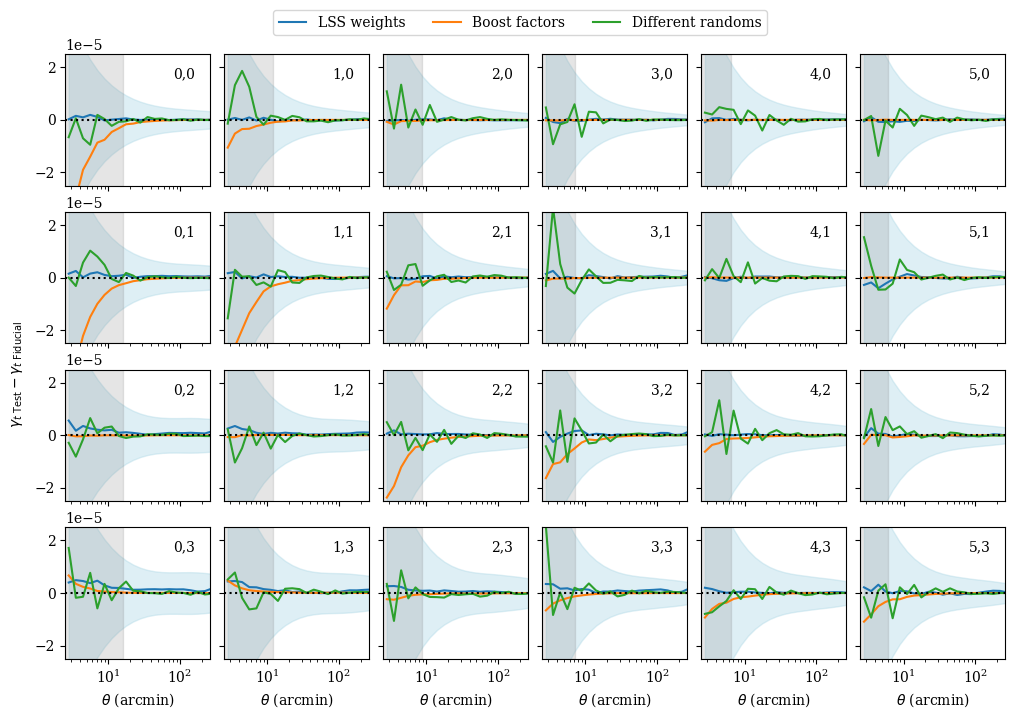

In [74]:

fig, ax = plt.subplots(4,6, figsize = (10,7), sharex = True, sharey = True)


plot_response = False
plot_shearw = False
handles_labels = {}
for l in range(6):
    for s in range(4):
        fid     = np.loadtxt('./2024-09-16_fid/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        nobf    = np.loadtxt('./2024-09-16_noB/gammat_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        # noresp  = np.loadtxt('./2024-09-16_noR/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        nolssw  = np.loadtxt('./2024-09-16_noW/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        diffrnd = np.loadtxt('./2024-09-16_rnd/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))

        # fid2   = np.loadtxt('.mdet_2023-10-16_fid_inteoria/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        # noresp   = np.loadtxt('.mdet_2023-10-16_noresp_wrong/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        # noresp2  = np.loadtxt('.mdet_2023-10-16_noresp/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))        
        
        ax[s,l].plot(fid[:,0], nolssw[:,1]-fid[:,1], label = 'LSS weights')
        ax[s,l].plot(fid[:,0], nobf[:,1]-fid[:,1], label = 'Boost factors')
        ax[s,l].plot(fid[:,0], diffrnd[:,1]-fid[:,1], label = 'Different randoms')
        if (plot_response == True):
            ax[s,l].plot(fid[:,0], noresp[:,1]-fid[:,1], label = 'Response')
        if (plot_shearw== True):
            ax[s,l].plot(fid[:,0], noshearw[:,1]-fid[:,1], label = 'Shear weights')
        # ax[s,l].plot(fid[:,0], noresp2[:,1]-fid[:,1], label = 'Response new')
        # ax[s,l].plot(fid[:,0], noshearw[:,1]-fid[:,1], label = 'Shear weights')
        # Example arrays for shaded area bounds
        y1 = - err_th[l][s]  # Lower bound
        y2 = + err_th[l][s]  # Upper bound
        
        ax[s,l].fill_between(fid[:, 0], y1, y2, color='lightblue', alpha=0.4)  # Add shaded area
        ax[s,l].axline((2.5, 0), (250, 0), c = 'black', linestyle = ':')
        ax[s,l].set_xscale('log')
        # ax[s,l].set_yscale('log')
        if (plot_response == True) or (plot_shearw == True):
            minlim = -0.0001
        else: 
            minlim = -0.000025
        maxlim = 0.000025
        ax[s,l].set_ylim(minlim, maxlim)
        ax[s,l].set_xlim(2.5, 260)
        ax[3,l].set_xlabel(r'$\theta$ (arcmin)')
        # ax[s,0].set_ylabel(r'$\gamma_t(\theta)(Test) - \gamma_t(\theta)(Fiducial)$')
        ax[s,l].text(0.9, 0.9, '{0},{1}'.format(l,s), 
                       horizontalalignment='right', 
                       verticalalignment='top', 
                       transform=ax[s,l].transAxes)
        ax[s,l].fill([2.5,2.5,scale_cuts[l],scale_cuts[l]],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)

        handles, labels = ax[s,l].get_legend_handles_labels()
        for handle, label in zip(handles, labels):
            handles_labels[label] = handle  
if (plot_response == True):
    fig.legend(handles_labels.values(), handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4, fancybox=True, shadow=False)
    fig.text(-0.01, 0.5, r'$\gamma_t(\rm Test) - \gamma_t(\rm Fiducial)$', va='center', rotation='vertical')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.1)
    plt.savefig('./plots/residuals_response.pdf', bbox_inches='tight')
if (plot_shearw == True):
    fig.legend(handles_labels.values(), handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, fancybox=True, shadow=False)
    fig.text(-0.01, 0.5, r'$\gamma_t(\rm Test) - \gamma_t(\rm Fiducial)$', va='center', rotation='vertical')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.1)
    plt.savefig('./plots/residuals_shearw.pdf', bbox_inches='tight')
else:
    fig.legend(handles_labels.values(), handles_labels.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3, fancybox=True, shadow=False)
    fig.text(-0.01, 0.5, r'$\gamma_{t\ \rm Test} - \gamma_{t\ \rm Fiducial}$', va='center', rotation='vertical')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.1)
    plt.savefig('./plots/residuals_final.png', bbox_inches='tight')


Now apply scale cuts

In [75]:
theta = asd[:,0]
masked_array = []
for l in range(6):
    for s in range(4):
        mask = (theta>scale_cuts[l]) & (theta<= 250.)
        masked_array.extend(mask)
masked_array = np.array(masked_array)

cov_masked = cov[masked_array,:][:,masked_array]

In [82]:
gammat_fid = []
gammat_sc_fid_masked = []

for l in range(6):
    for s in range(4):
        asd = np.loadtxt('./2024-09-16_fid/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        mask = (asd[:,0]>scale_cuts[l]) & (asd[:,0]<= 250.)
        gammat_fid.extend(asd[:,1])
        gammat_sc_fid_masked.extend(asd[:,1][mask])
             
gammat_sc_fid_masked = np.array(gammat_sc_fid_masked)    
gammat_fid = np.array(gammat_fid)    
print (gammat_sc_fid_masked.shape)


gammat_noB = []
gammat_sc_noB_masked = []

for l in range(6):
    for s in range(4):
        asd = np.loadtxt('./2024-09-16_noB/gammat_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        mask = (asd[:,0]>scale_cuts[l]) & (asd[:,0]<= 250.)
        gammat_noB.extend(asd[:,1])
        gammat_sc_noB_masked.extend(asd[:,1][mask])
             
gammat_sc_noB_masked = np.array(gammat_sc_noB_masked)    
gammat_noB = np.array(gammat_noB)    
print (gammat_sc_noB_masked.shape)


gammat_now = []
gammat_sc_now_masked = []

for l in range(6):
    for s in range(4):
        asd = np.loadtxt('./2024-09-16_noW/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        mask = (asd[:,0]>scale_cuts[l]) & (asd[:,0]<= 250.)
        gammat_now.extend(asd[:,1])
        gammat_sc_now_masked.extend(asd[:,1][mask])
             
gammat_sc_now_masked = np.array(gammat_sc_now_masked)    
gammat_now = np.array(gammat_now)    
print (gammat_sc_now_masked.shape)


gammat_rnd = []
gammat_sc_rnd_masked = []

for l in range(6):
    for s in range(4):
        asd = np.loadtxt('./2024-09-16_rnd/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        mask = (asd[:,0]>scale_cuts[l]) & (asd[:,0]<= 250.)
        gammat_rnd.extend(asd[:,1])
        gammat_sc_rnd_masked.extend(asd[:,1][mask])
             
gammat_sc_rnd_masked = np.array(gammat_sc_rnd_masked)    
gammat_rnd = np.array(gammat_rnd)    
print (gammat_sc_rnd_masked.shape)


gammat_noR = []
gammat_sc_noR_masked = []

for l in range(6):
    for s in range(4):
        asd = np.loadtxt('./2024-09-16_noR/gammat_bf_rp/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        mask = (asd[:,0]>scale_cuts[l]) & (asd[:,0]<= 250.)
        gammat_noR.extend(asd[:,1])
        gammat_sc_noR_masked.extend(asd[:,1][mask])
             
gammat_sc_noR_masked = np.array(gammat_sc_noR_masked)    
gammat_noR = np.array(gammat_noR)    
print (gammat_sc_noR_masked.shape)

(348,)
(348,)
(348,)
(348,)
(348,)


In [83]:
gammat_cov_INV = np.linalg.inv(cov)
gammat_cov_masked_INV = np.linalg.inv(cov_masked)

In [84]:
chi2 = (gammat_now-gammat_fid).T @ gammat_cov_INV @ (gammat_now-gammat_fid)
print (chi2, chi2/len(gammat_fid))

chi2_sc = (gammat_sc_now_masked-gammat_sc_fid_masked).T @ gammat_cov_masked_INV @ (gammat_sc_now_masked-gammat_sc_fid_masked)
print (chi2_sc, chi2_sc/len(gammat_sc_fid_masked))

8.159333508349063 0.013075854981328626
1.0235859884300589 0.002941339047212813


In [85]:
chi2 = (gammat_noB-gammat_fid).T @ gammat_cov_INV @ (gammat_noB-gammat_fid)
print (chi2, chi2/len(gammat_fid))

chi2_sc = (gammat_sc_noB_masked-gammat_sc_fid_masked).T @ gammat_cov_masked_INV @ (gammat_sc_noB_masked-gammat_sc_fid_masked)
print (chi2_sc, chi2_sc/len(gammat_sc_fid_masked))

7.115977971568058 0.011403810851871888
0.3880043594615823 0.0011149550559240871


In [86]:
chi2 = (gammat_rnd-gammat_fid).T @ gammat_cov_INV @ (gammat_rnd-gammat_fid)
print (chi2, chi2/len(gammat_fid))

chi2_sc = (gammat_sc_rnd_masked-gammat_sc_fid_masked).T @ gammat_cov_masked_INV @ (gammat_sc_rnd_masked-gammat_sc_fid_masked)
print (chi2_sc, chi2_sc/len(gammat_sc_fid_masked))

15.73797021282516 0.025221106110296734
8.344954326057099 0.023979753810508906


In [ ]:
# from scipy.stats import chi2
# p_value = 1 - chi2.cdf(chi2_sc_gammax, len(gammax_sc_fid))
# p_value

## compare jackknife covariance to new theory covariance

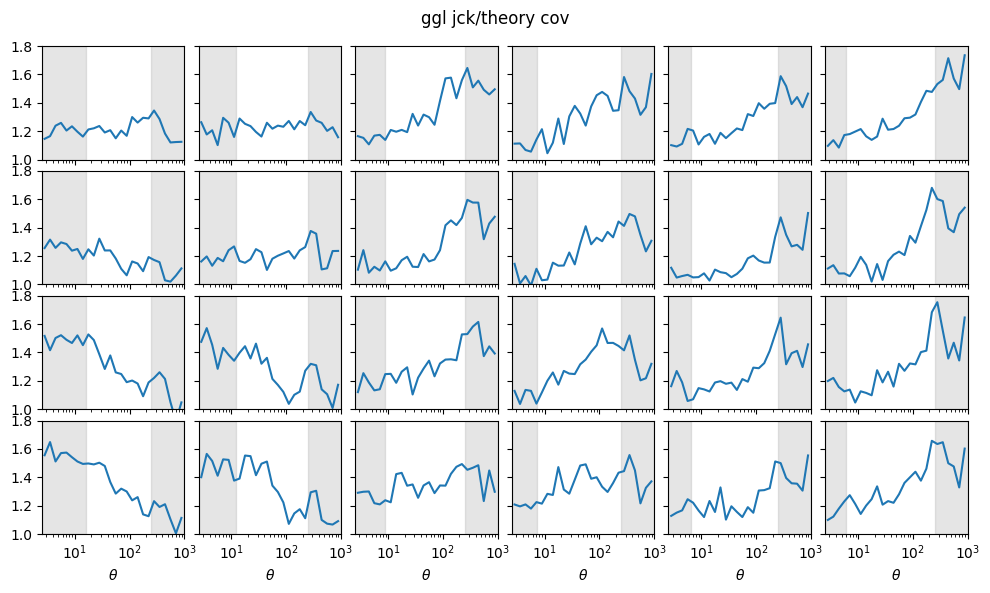

In [8]:
fig, ax = plt.subplots(4,6, figsize = (10,6), sharex = True, sharey = True)

for l in range(6):
    for s in range(4):
        asd = np.loadtxt('./2024-09-16_fid/Jackknife/gammat_covariance/err_gammat_l{0}_s{1}.txt'.format(l+1, s+1))

        ax[s,l].plot(asd[:,0], (asd[:,1])/err[l,s])
        # ax[s,l].plot(asd[:,0], asd[:,1], label = 'Jackknife cov')
        minlim = 1
        maxlim = 1.8
        ax[s,l].set_ylim(minlim, maxlim)
        ax[s,l].set_xlim(2.5, 1000)
        ax[s,l].fill([2.5,2.5,scale_cuts[l],scale_cuts[l]],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        ax[s,l].fill([250, 250, 1000, 1000],[minlim,maxlim,maxlim,minlim],  color='gray', alpha=0.2)
        # ax[s,0].set_ylabel('(jck-th)/th')
        ax[3,l].set_xlabel(r'$\theta$')
        
# plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.suptitle('ggl jck/theory cov')
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.1)
plt.savefig('./plots/comp_cov_err_final_resf.pdf')
